### Install Libraries

This cell installs the necessary Python libraries for the project, including `openai`, `anthropic`, `pillow`, `matplotlib`, `pandas`, `scikit-learn`, and `pypdf2`. These libraries are required for interacting with the language models, handling images, performing data analysis and visualization, and processing PDF files.

In [27]:
!pip install --upgrade openai anthropic pillow matplotlib pandas scikit-learn pypdf2

### Helper Functions: Image Handling and JSON

This cell defines utility functions:
- `encode_image_to_b64`: Encodes an image file to a base64 string for API calls.
- `save_json`: Saves a Python object to a JSON file.
- `load_images_via_colab`: Provides a Colab-specific method to upload files directly into the notebook environment and saves them to the image directory.

In [26]:
def encode_image_to_b64(path: str) -> str:
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def save_json(obj: Any, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def load_images_via_colab() -> List[str]:
    """Return list of file paths in ./uploaded_images after Colab upload."""
    uploaded = files.upload()  # user picks files
    paths = []
    for fname, data in uploaded.items():
        p = IMG_DIR / fname
        with open(p, "wb") as f:
            f.write(data)
        paths.append(str(p))
    return paths

### Setup Environment and Directories

This cell sets up the environment by attempting to load API keys for OpenAI and Anthropic from environment variables (recommended for security). It also defines project folders for uploaded images, reference materials (for RAG), and results, creating these directories if they don't exist. A unique run tag is generated for logging purposes.

In [22]:
# --- API keys (recommended to set as env vars) ---
# In Colab:  Menu → Edit → Notebook settings → Secrets → Manage environment variables
openai.api_key = os.getenv("OPENAI_API_KEY", "")
anthropic.api_key = os.getenv("ANTHROPIC_API_KEY", "")

if not openai.api_key:
    print("⚠️ Missing OPENAI_API_KEY (set in environment for security).")
if not anthropic.api_key:
    print("⚠️ Missing ANTHROPIC_API_KEY (set in environment for security).")

# --- Project folders ---
ROOT = Path(".").resolve()
IMG_DIR = ROOT / "uploaded_images"
REF_DIR = ROOT / "materials_references"   # (Optional RAG corpus)
OUT_DIR = ROOT / "results"

IMG_DIR.mkdir(exist_ok=True, parents=True)
REF_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR.mkdir(exist_ok=True, parents=True)

# --- Experiment label for logging ---
RUN_TAG = datetime.datetime.now().strftime("defectrag_sem_%Y%m%d_%H%M%S")
print("Run tag:", RUN_TAG)

⚠️ Missing OPENAI_API_KEY (set in environment for security).
⚠️ Missing ANTHROPIC_API_KEY (set in environment for security).
Run tag: defectrag_sem_20251020_063555


### Helper Functions: Image Handling and JSON

This cell defines utility functions:
- `encode_image_to_b64`: Encodes an image file to a base64 string for API calls.
- `save_json`: Saves a Python object to a JSON file.
- `load_images_via_colab`: Provides a Colab-specific method to upload files directly into the notebook environment and saves them to the image directory.

In [23]:
def encode_image_to_b64(path: str) -> str:
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def save_json(obj: Any, path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def load_images_via_colab() -> List[str]:
    """Return list of file paths in ./uploaded_images after Colab upload."""
    uploaded = files.upload()  # user picks files
    paths = []
    for fname, data in uploaded.items():
        p = IMG_DIR / fname
        with open(p, "wb") as f:
            f.write(data)
        paths.append(str(p))
    return paths

### Helper Functions: RAG (Retrieval Augmented Generation)

This cell contains functions for setting up and using an optional RAG corpus:
- `load_pdf_corpus`: Reads text content from PDF files in a specified folder.
- `build_vector_store`: Creates a TF-IDF vector representation of the document corpus.
- `retrieve_context`: Finds the most semantically similar document chunks to a given query using cosine similarity.

In [24]:
def load_pdf_corpus(folder: Path = REF_DIR) -> Tuple[List[str], List[str]]:
    """Return (docs, names) for all PDFs in folder."""
    from PyPDF2 import PdfReader
    docs, names = [], []
    for f in folder.glob("*.pdf"):
        try:
            text = ""
            reader = PdfReader(str(f))
            for page in reader.pages:
                text += (page.extract_text() or "") + "\n"
            docs.append(text)
            names.append(f.name)
        except Exception as e:
            print(f"PDF load error [{f.name}]: {e}")
    return docs, names

def build_vector_store(docs: List[str]) -> Tuple[TfidfVectorizer, Any]:
    vect = TfidfVectorizer(stop_words="english", max_features=8000)
    X = vect.fit_transform(docs)
    return vect, X

def retrieve_context(query: str, vect: TfidfVectorizer, X: Any, docs: List[str], k: int = 3, max_chars: int = 1200) -> str:
    qv = vect.transform([query])
    sims = cosine_similarity(qv, X)[0]
    idxs = np.argsort(sims)[::-1][:k]
    chunks = []
    for i in idxs:
        chunk = docs[i][:max_chars]
        chunks.append(chunk)
    return "\n\n---\n\n".join(chunks)

### Helper Function: Claude Model Selection

This cell defines a function `pick_latest_claude_model` to programmatically determine the most recent and preferred Claude model available via the Anthropic API, prioritizing newer versions like Sonnet 4.5.

In [25]:
def pick_latest_claude_model(prefer_sonnet: bool = True) -> str:
    """
    Return the newest Claude 4.x model id you can access.
    Priority: Sonnet 4.5 → Haiku 4.5 → 'claude-sonnet-4' alias → 3.5 fallback.
    """
    client = anthropic.Anthropic(api_key=anthropic.api_key)
    model_ids = []
    try:
        models = client.models.list()  # requires a reasonably recent anthropic SDK
        model_ids = [m.id for m in models.data]
    except Exception:
        # listing may fail (older SDK/permissions); we'll use known names
        pass

    candidates_priority = [
        "claude-sonnet-4.5",
        "claude-sonnet-4-5-20250929",  # dated alias seen in some tenants
        "claude-haiku-4.5",
        "claude-haiku-4-5-20251015",
        "claude-sonnet-4",             # generic 4.x alias
        "claude-3-5-sonnet-latest"     # last-resort fallback
    ]

    if model_ids:
        for mid in candidates_priority:
            if mid in model_ids:
                return mid
    # If we can't list or no match, try the most likely top option:
    return "claude-sonnet-4.5"

In [5]:
def load_pdf_corpus(folder: Path = REF_DIR) -> Tuple[List[str], List[str]]:
    """Return (docs, names) for all PDFs in folder."""
    from PyPDF2 import PdfReader
    docs, names = [], []
    for f in folder.glob("*.pdf"):
        try:
            text = ""
            reader = PdfReader(str(f))
            for page in reader.pages:
                text += (page.extract_text() or "") + "\n"
            docs.append(text)
            names.append(f.name)
        except Exception as e:
            print(f"PDF load error [{f.name}]: {e}")
    return docs, names

def build_vector_store(docs: List[str]) -> Tuple[TfidfVectorizer, Any]:
    vect = TfidfVectorizer(stop_words="english", max_features=8000)
    X = vect.fit_transform(docs)
    return vect, X

def retrieve_context(query: str, vect: TfidfVectorizer, X: Any, docs: List[str], k: int = 3, max_chars: int = 1200) -> str:
    qv = vect.transform([query])
    sims = cosine_similarity(qv, X)[0]
    idxs = np.argsort(sims)[::-1][:k]
    chunks = []
    for i in idxs:
        chunk = docs[i][:max_chars]
        chunks.append(chunk)
    return "\n\n---\n\n".join(chunks)


In [6]:
def pick_latest_claude_model(prefer_sonnet: bool = True) -> str:
    """
    Return the newest Claude 4.x model id you can access.
    Priority: Sonnet 4.5 → Haiku 4.5 → 'claude-sonnet-4' alias → 3.5 fallback.
    """
    client = anthropic.Anthropic(api_key=anthropic.api_key)
    model_ids = []
    try:
        models = client.models.list()  # requires a reasonably recent anthropic SDK
        model_ids = [m.id for m in models.data]
    except Exception:
        # listing may fail (older SDK/permissions); we'll use known names
        pass

    candidates_priority = [
        "claude-sonnet-4.5",
        "claude-sonnet-4-5-20250929",  # dated alias seen in some tenants
        "claude-haiku-4.5",
        "claude-haiku-4-5-20251015",
        "claude-sonnet-4",             # generic 4.x alias
        "claude-3-5-sonnet-latest"     # last-resort fallback
    ]

    if model_ids:
        for mid in candidates_priority:
            if mid in model_ids:
                return mid
    # If we can't list or no match, try the most likely top option:
    return "claude-sonnet-4.5"


In [16]:
def build_system_message() -> str:
    return (
        "You are an expert in Scanning Electron Microscopy (SEM) and semiconductor defect analysis. "
        "Provide technically precise, concise interpretations. If supporting text context is provided, "
        "use it to inform hypotheses and cite it as 'retrieved context' rather than factual ground truth."
    )

def get_image_media_type(image_path: str) -> str:
    """Determine image media type from file extension."""
    suffix = Path(image_path).suffix.lower()
    if suffix in {".png"}:
        return "image/png"
    elif suffix in {".jpg", ".jpeg"}:
        return "image/jpeg"
    elif suffix in {".gif"}:
        return "image/gif"
    elif suffix in {".tif", ".tiff"}:
        # TIFF is not directly supported by Anthropic multimodal as of now,
        # but we'll return a type for completeness. Will likely fail.
        return "image/tiff"
    else:
        # Default to PNG if unknown, though this might fail
        return "image/png"


def build_openai_messages(image_b64: str, user_prompt: str, context_text: str = "") -> List[Dict[str, Any]]:
    """OpenAI chat.completions multimodal format."""
    combined_text = user_prompt
    if context_text:
        combined_text += f"\n\nRetrieved context:\n{context_text}"

    return [
        {"role": "system", "content": build_system_message()},
        {"role": "user", "content": [
            {"type": "text", "text": "Analyze this SEM sample."},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}},
            {"type": "text", "text": combined_text}
        ]}
    ]

def build_anthropic_messages(image_path: str, image_b64: str, user_prompt: str, context_text: str = "") -> Tuple[str, List[Dict[str, Any]]]:
    """Anthropic Messages API multimodal format (system separate)."""
    combined_text = user_prompt
    if context_text:
        combined_text += f"\n\nRetrieved context:\n{context_text}"

    system_msg = build_system_message()
    msgs = [
        {"role": "user", "content": [
            {"type": "text", "text": combined_text},
            {"type": "image", "source": {
                "type": "base64", "media_type": get_image_media_type(image_path), "data": image_b64
            }}
        ]}
    ]
    return system_msg, msgs

In [17]:
def call_openai(messages: List[Dict[str, Any]], model: str = "gpt-4o-mini", max_tokens: int = 1000):
    try:
        t0 = time.time()
        resp = openai.chat.completions.create(model=model, messages=messages, max_tokens=max_tokens)
        latency = time.time() - t0
        text = resp.choices[0].message.content.strip() if resp.choices else ""
        usage = {
            "model": model,
            "input": getattr(resp.usage, "prompt_tokens", 0),
            "output": getattr(resp.usage, "completion_tokens", 0),
            "latency_sec": latency
        }
        return text, usage
    except Exception as e:
        print(f"OpenAI error: {e}")
        return None, None

def call_claude(system_msg: str, msgs: List[Dict[str, Any]], preferred_model: Optional[str] = None, max_tokens: int = 1000):
    try:
        client = anthropic.Anthropic(api_key=anthropic.api_key)
        model_id = preferred_model or pick_latest_claude_model(prefer_sonnet=True)
        t0 = time.time()
        resp = client.messages.create(model=model_id, system=system_msg, messages=msgs, max_tokens=max_tokens)
        latency = time.time() - t0

        out_text = ""
        if resp.content and getattr(resp.content[0], "type", "") == "text":
            out_text = resp.content[0].text.strip()

        usage = {
            "model": model_id,
            "input": getattr(resp.usage, "input_tokens", 0),
            "output": getattr(resp.usage, "output_tokens", 0),
            "latency_sec": latency
        }
        return out_text, usage
    except Exception as e:
        print(f"Anthropic error: {e}")
        return None, None


In [18]:
def agentic_analyze_one(
    image_path: str,
    user_prompt: str,
    enable_rag: bool = False,
    vect: Optional[TfidfVectorizer] = None,
    X: Optional[Any] = None,
    docs: Optional[List[str]] = None,
    openai_model: str = "gpt-4o-mini",
    claude_model_preferred: Optional[str] = None
) -> Dict[str, Any]:
    """
    Core step for one image: build prompts, (optionally) retrieve context, call both models.
    Returns a dict with responses + token/latency usage.
    """
    img_b64 = encode_image_to_b64(image_path)

    context_text = ""
    if enable_rag and vect is not None and X is not None and docs:
        context_text = retrieve_context(user_prompt, vect, X, docs, k=3, max_chars=1200)

    # Build messages
    oai_msgs = build_openai_messages(img_b64, user_prompt, context_text)
    claude_system, claude_msgs = build_anthropic_messages(image_path, img_b64, user_prompt, context_text)

    # Call models
    oai_text, oai_usage = call_openai(oai_msgs, model=openai_model)
    claude_text, claude_usage = call_claude(claude_system, claude_msgs, preferred_model=claude_model_preferred)

    return {
        "image_path": image_path,
        "prompt": user_prompt,
        "context_used": bool(context_text),
        "openai": {"text": oai_text, "usage": oai_usage},
        "anthropic": {"text": claude_text, "usage": claude_usage},
    }

In [19]:
def run_experiment(
    image_paths: List[str],
    prompts: List[str],
    enable_rag: bool = False,
    vect: Optional[TfidfVectorizer] = None,
    X: Optional[Any] = None,
    docs: Optional[List[str]] = None,
    openai_model: str = "gpt-4o-mini",
    claude_model_preferred: Optional[str] = None
) -> List[Dict[str, Any]]:
    logs = []
    for idx, (p, q) in enumerate(zip(image_paths, prompts), start=1):
        print(f"\n=== Experiment {idx} / {len(image_paths)} ===")
        result = agentic_analyze_one(
            image_path=p,
            user_prompt=q,
            enable_rag=enable_rag,
            vect=vect, X=X, docs=docs,
            openai_model=openai_model,
            claude_model_preferred=claude_model_preferred
        )
        logs.append(result)
    return logs


In [20]:
def summarize_logs_to_df(logs: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for i, entry in enumerate(logs, start=1):
        o = entry.get("openai", {})
        a = entry.get("anthropic", {})
        ou = (o.get("usage") or {})
        au = (a.get("usage") or {})
        rows.append({
            "Image": f"Image {i}",
            "OpenAI_model": ou.get("model", ""),
            "Claude_model": au.get("model", ""),
            "OpenAI_input": ou.get("input", 0),
            "OpenAI_output": ou.get("output", 0),
            "OpenAI_latency_s": round(ou.get("latency_sec", 0), 3),
            "Claude_input": au.get("input", 0),
            "Claude_output": au.get("output", 0),
            "Claude_latency_s": round(au.get("latency_sec", 0), 3),
            "Context_used": entry.get("context_used", False)
        })
    return pd.DataFrame(rows)

def plot_usage(df: pd.DataFrame, title: str = "LLM Token Usage & Latency Comparison"):
    # Tokens
    plt.figure(figsize=(10,5))
    df.plot(
        x="Image",
        y=["OpenAI_input", "OpenAI_output", "Claude_input", "Claude_output"],
        kind="bar"
    )
    plt.title(title)
    plt.ylabel("Tokens")
    plt.grid(axis="y", linestyle="--")
    plt.tight_layout()
    plt.show()

    # Latency
    plt.figure(figsize=(8,4))
    df.plot(
        x="Image",
        y=["OpenAI_latency_s", "Claude_latency_s"],
        kind="bar"
    )
    plt.title("Latency (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis="y", linestyle="--")
    plt.tight_layout()
    plt.show()

def export_results(logs: List[Dict[str, Any]], df: pd.DataFrame, run_tag: str = RUN_TAG):
    # JSON: full logs with text
    json_path = OUT_DIR / f"{run_tag}_logs.json"
    save_json(logs, json_path)

    # CSV: clean table
    csv_path = OUT_DIR / f"{run_tag}_summary.csv"
    df.to_csv(csv_path, index=False)

    print(f"💾 Saved JSON → {json_path}")
    print(f"💾 Saved CSV  → {csv_path}")


📥 Upload exactly 3 images (PNG/JPG preferred)


Saving Intel_Pentium_4-SEM.JPG to Intel_Pentium_4-SEM.JPG
Saving TiW_AFM_Tip_Composition_Table.JPG to TiW_AFM_Tip_Composition_Table (1).JPG
Saving X_Sectioned_Device.png to X_Sectioned_Device.png


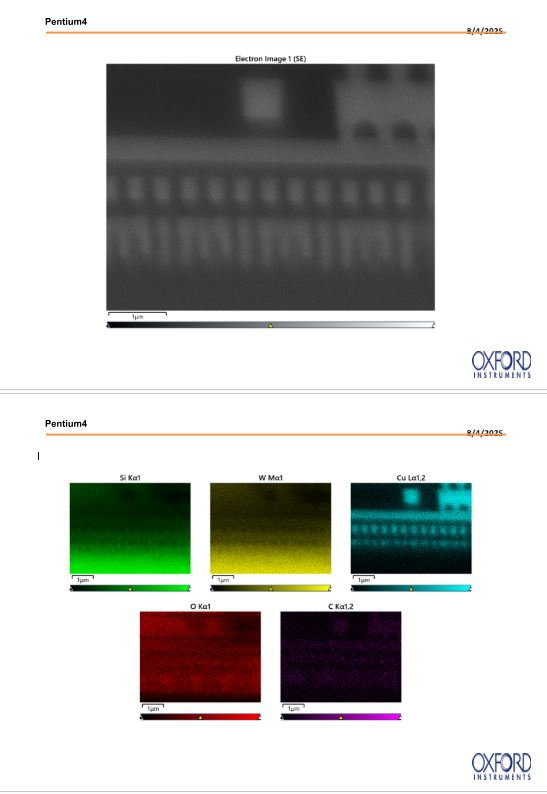

Enter description for Image 1: Explain these images, they are from a Intel Pentium 4. 


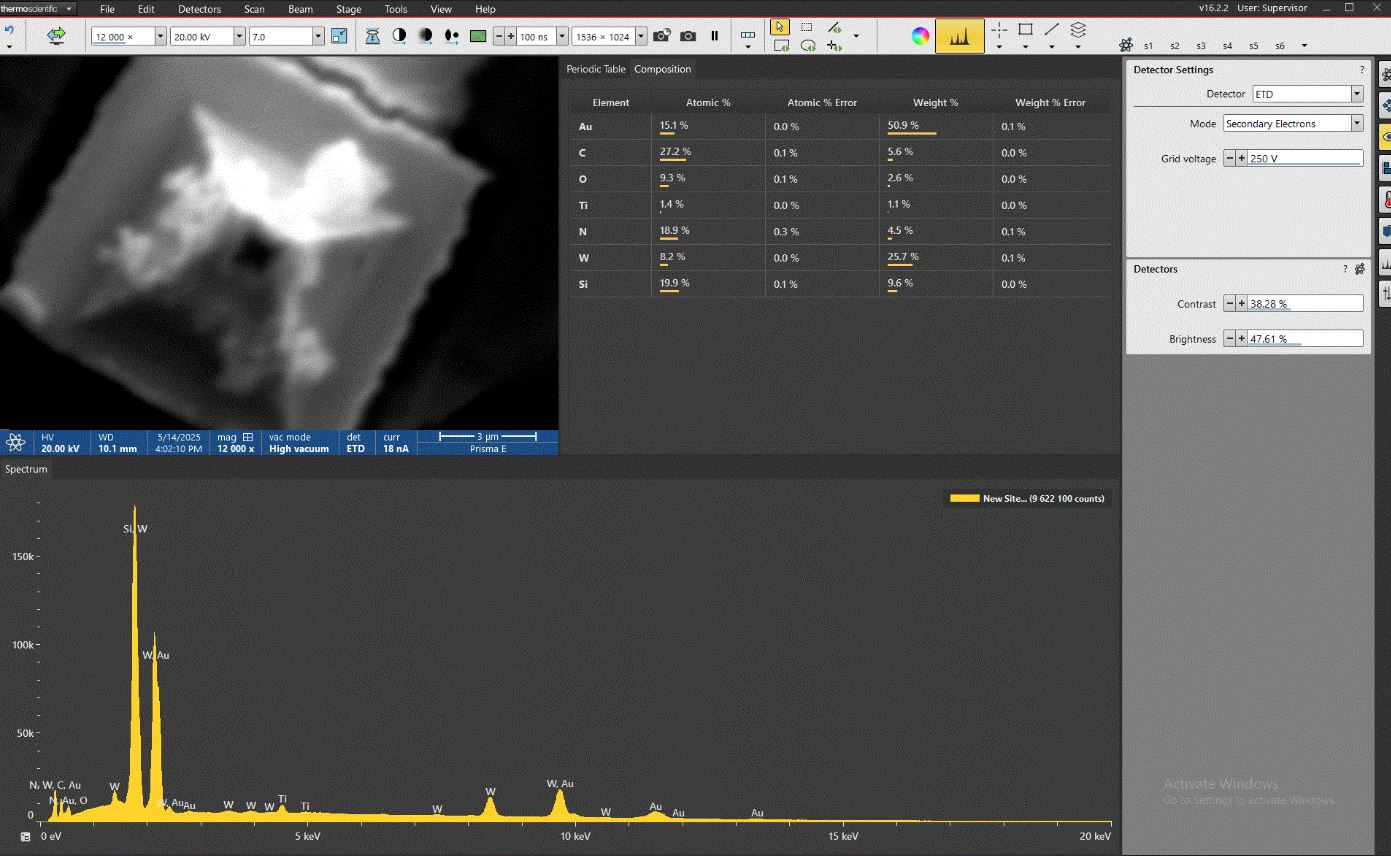

Enter description for Image 2: This is an SEM image of an AFM tip (TiW alloy). Tell me about the surface morpholoy and the compositional data in the table.


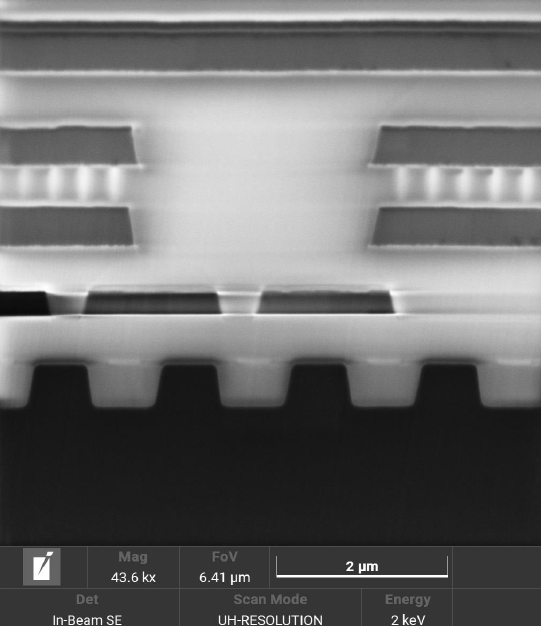

Enter description for Image 3: This is a X-section of a device. Tell me about this image generally. Then, focus on the subtle vertical lines that span between the dark structures. What could they be> 

=== Experiment 1 / 3 ===

=== Experiment 2 / 3 ===

=== Experiment 3 / 3 ===

=== Responses for Image 1 ===


####  OpenAI GPT-4o-mini
The provided SEM images showcase an analysis of a semiconductor sample, specifically from an Intel Pentium 4 processor. Here’s a breakdown of the key elements visible in the images:

### 1. **Electron Image (SE)**
- The top image is a Secondary Electron (SE) image, which provides a high-resolution view of the surface topography.
- It reveals features such as the arrangement of transistors or other microscopic structures on the chip. The scale bar indicates that the image resolution is at a micrometer level, which is typical for semiconductor features.

### 2. **Elemental Mapping Images**
The bottom images represent elemental maps obtained using Energy Dispersive X-ray Spectroscopy (EDS), often displayed in false colors for clarity:

- **Si Kα1 (Silicon)**
  - Predominantly green, this map highlights the silicon areas, essential in semiconductors as the primary substrate material.

- **W Mα1 (Tungsten)**
  - Shown in yellow, tungsten may be used in via fills or interconnects due to its good conductivity and high melting point.

- **Cu Lα1 (Copper)**
  - Represented in blue, copper is often used for wiring and interconnections within the chip due to its excellent electrical conductivity.

- **O Kα1 (Oxygen)**
  - Displayed in red, oxygen may indicate areas of silicon oxide, which is commonly used as an insulator or passivation layer in semiconductor devices.

- **C Kα2 (Carbon)**
  - The purple areas map carbon presence; carbon may be found in certain dielectric materials or polymer-based components.

### Conclusion
These images provide insights into both the topological features and elemental composition of the Pentium 4 die. Analyzing these maps allows for the identification of material distributions, potential defects, and the overall integrity of the semiconductor fabrication process. The presence of different elements also indicates layers and structures integral to the chip's functionality.

####  Anthropic Claude (latest)
# SEM/EDS Analysis of Intel Pentium 4 Cross-Section

## Image 1: SEM Cross-Section
This electron microscopy image shows a **cross-sectional view of the Pentium 4's back-end-of-line (BEOL) metallization stack**. Key features:

- **Horizontal metal lines**: The bright, periodic rectangular structures arranged in two distinct rows represent metal interconnect layers
- **Dielectric layers**: The darker gray regions between metal features are inter-layer dielectric (ILD) materials, likely SiO₂-based low-k dielectrics
- **Via structures**: The vertical connections between metal layers are visible as darker rectangular features
- **Scale**: The 1μm scale bar indicates these are likely M1/M2 level interconnects (lower metal layers)
- **Material contrast**: The brightness variation in SEM indicates Z-contrast (atomic number contrast), with metal appearing brighter than dielectric

## Image 2: EDS Elemental Mapping
The Energy Dispersive X-ray Spectroscopy (EDS) maps reveal the **chemical composition** of the cross-section:

1. **Si Kα1 (Green)**: Strong uniform signal from the silicon substrate/dielectric materials
2. **W Mα1 (Yellow)**: Tungsten distribution, likely from:
   - Tungsten plugs/vias connecting metal layers
   - Possible contact studs to lower levels
3. **Cu Lα1,2 (Cyan)**: Copper signal showing the **dual-damascene copper interconnects** - confirms Pentium 4's use of copper metallization technology
4. **O Kα1 (Red)**: Oxygen map highlighting the oxide-based dielectric materials
5. **C Kα1,2 (Purple)**: Carbon signal, possibly from:
   - Low-k dielectric materials (carbon-doped oxides)
   - Sample preparation artifacts

This analysis confirms the **0.13μm or 90nm process node** copper/low-k interconnect technology typical of Pentium 4 processors (Northwood/Prescott cores).


=== Responses for Image 2 ===


####  OpenAI GPT-4o-mini
### SEM Sample Analysis

**Surface Morphology:**
The SEM image shows a three-dimensional structure indicative of an Atomic Force Microscopy (AFM) tip. The visible features include sharp edges and a defined geometric shape, typical of AFM tips designed for high-resolution imaging. The roughness and topographical variances observed could impact the tip's performance in imaging nanoscale surfaces.

### Compositional Data Analysis
The elemental composition is listed as follows:

| Element | Atomic % | Weight % |
|---------|----------|----------|
| Au      | 15.1     | 50.9     |
| C       | 27.2     | 5.6      |
| O       | 9.3      | 2.6      |
| Ti      | 1.4      | 2.1      |
| N       | 18.9     | 4.5      |
| W       | 8.2      | 25.7     |
| Si      | 19.9     | 9.6      |

**Elemental Breakdown:**
- **Gold (Au)**: Highest weight percentage, primarily contributing to conductivity and stability.
- **Carbon (C)**: Significant presence, possibly from organic contaminants or coatings; low contribution to weight suggests its role in functionalization rather than structural support.
- **Oxygen (O)**: Indicates potential oxidation or the presence of surface oxides; requires further investigation depending on application.
- **Titanium (Ti)** and **Tungsten (W)**: These metals typically enhance durability and mechanical strength; their minor presence suggests they may be used in alloying to improve tip toughness.
- **Nitrogen (N)**: Its presence might indicate surface treatment or nitrogen doping for enhanced performance.
- **Silicon (Si)**: Commonly used in semiconductor applications, which may suggest the tip's context within microelectronic systems.

### Conclusion
The SEM image reveals the characteristic morphology of an AFM tip, while the compositional data indicates the use of a titanium-tungsten alloy with gold for enhanced electrical properties. The presence of carbon and oxygen suggests some surface interactions or contaminations that might influence performance. Further investigation, including elemental mapping and phase analysis, would provide more insights into the material's suitability for its intended application.

####  Anthropic Claude (latest)
## Surface Morphology Analysis

The SEM image shows an AFM tip with the following characteristics:

**Morphological Features:**
- **Tip geometry**: The probe exhibits a pyramidal/conical apex with relatively sharp termination
- **Surface texture**: Granular microstructure visible across the entire tip surface, consistent with polycrystalline TiW alloy
- **Grain structure**: Fine-grained morphology (likely sub-100nm grain size) typical of sputtered or deposited refractory metal films
- **Surface roughness**: Moderate nanoscale roughness evident from the grainy texture
- **Bright contrast regions**: Appear at the apex and certain facets, indicating either topographic high points or compositional variations (higher atomic number phases)

## Compositional Analysis (EDX Data)

**Primary Constituents:**
- **Au (15.1 at%, 50.9 wt%)**: Likely a conductive coating applied for SEM imaging or electrical contact enhancement
- **W (8.2 at%, 25.7 wt%)**: Tungsten component of the TiW alloy
- **Ti (1.4 at%, 1.1 wt%)**: Titanium component (appears lower than expected for standard TiW compositions)

**Contaminants/Adventitious Species:**
- **C (27.2 at%, 5.6 wt%)**: Carbon contamination from air exposure, hydrocarbon deposition, or sample handling
- **O (9.3 at%, 2.6 wt%)**: Surface oxidation of Ti and potentially W
- **N (18.9 at%, 4.5 wt%)**: Nitrogen from atmosphere or possible TiN formation
- **Si (19.9 at%, 9.6 wt%)**: Significant silicon presence, possibly from substrate, mounting material, or contamination

**Interpretation:**
The Ti:W atomic ratio (~1:6) is atypical for standard TiW alloys (usually Ti:W ranges from 10:90 to 30:70). The substantial Au coating dominates the weight percentage. The high C, N, and Si content suggests either surface contamination or contributions from the substrate/mounting region within the EDX interaction volume.


=== Responses for Image 3 ===


####  OpenAI GPT-4o-mini
The image depicts a scanning electron microscopy (SEM) cross-section of a semiconductor device, showcasing fine features at a high magnification of 43.6 kx with a field of view (FoV) of 6.41 µm. The left and right sections appear to have alternating darker and lighter regions, indicating different materials or layers, likely part of a complex device architecture such as a MOSFET or similar semiconductor technology.

Focusing on the subtle vertical lines that span between the darker structures, these could represent several phenomena:

1. **Surface Roughness**: The vertical lines may indicate variations in surface texture at the nanoscale, possibly resulting from etching, deposition processes, or material characteristics.

2. **Grain Boundaries**: If the material is polycrystalline, these lines could correspond to grain boundaries where different crystalline orientations meet.

3. **Defect Structures**: The lines could be manifestations of defects such as dislocations or other crystallographic imperfections.

4. **Etch Patterns**: If the device underwent a dry etching process, the vertical lines might reflect the etching technique used, potentially revealing underlying patterns depending on the etchant's selectivity for different materials.

5. **Charge Manifestation**: In some cases, vertical lines can indicate charge buildup in the material, especially in heterostructures or layered devices where interfaces are present.

A deeper analysis, possibly involving complementary techniques such as X-ray diffraction or transmission electron microscopy (TEM), may provide more insights into the nature of these features.

####  Anthropic Claude (latest)
# General Overview

This is a **cross-sectional SEM image** of a semiconductor device acquired using in-beam secondary electron (SE) detection at 2 keV in ultra-high resolution mode. The image reveals a complex multilayer structure typical of advanced integrated circuits, showing:

- **Top layers**: Horizontal metal interconnect lines with dielectric layers between them
- **Middle region**: A large inter-level dielectric (ILD) region with patterned metal structures on both sides
- **Lower region**: What appears to be substrate or lower-level device structures with periodic dark features (possibly transistor gates or STI trenches)

The stratified architecture suggests this is likely from the **back-end-of-line (BEOL)** metallization layers down to the **front-end-of-line (FEOL)** active device region.

---

# Subtle Vertical Lines Analysis

The **subtle vertical lines spanning between the dark structures** in the central dielectric region are most likely:

## **1. Charging Artifacts (Most Probable)**
These lines could be **electron beam-induced charging striations** caused by:
- Differential charging in thick dielectric materials during scanning
- The low 2 keV accelerating voltage limits conductivity through insulators
- Non-uniform charge dissipation creating scan-direction artifacts

## **2. Curtaining Effect**
A common SEM cross-section artifact where:
- Ion milling or FIB preparation creates differential removal rates
- Subsurface density variations cause topographic striations
- These propagate vertically through softer materials

## **3. Physical Structures (Less Likely but Possible)**
They could represent:
- **Through-silicon vias (TSVs)** or partial via structures
- **Etch residues** or material interfaces
- Very faint **barrier layers** or **liner remnants** from via/contact formation

The regularity and vertical orientation spanning multiple material layers suggest **preparation or imaging artifacts** rather than intentional device structures, though without higher magnification or complementary imaging, physical features cannot be entirely ruled out.

,Image,OpenAI_model,Claude_model,OpenAI_input,OpenAI_output,OpenAI_latency_s,Claude_input,Claude_output,Claude_latency_s,Context_used
0,Image 1,gpt-4o-mini,claude-sonnet-4-5-20250929,25584,402,8.767,667,491,14.267,False
1,Image 2,gpt-4o-mini,claude-sonnet-4-5-20250929,36935,471,10.448,1656,519,14.713,False
2,Image 3,gpt-4o-mini,claude-sonnet-4-5-20250929,25606,309,4.615,568,469,14.531,False


<Figure size 1000x500 with 0 Axes>

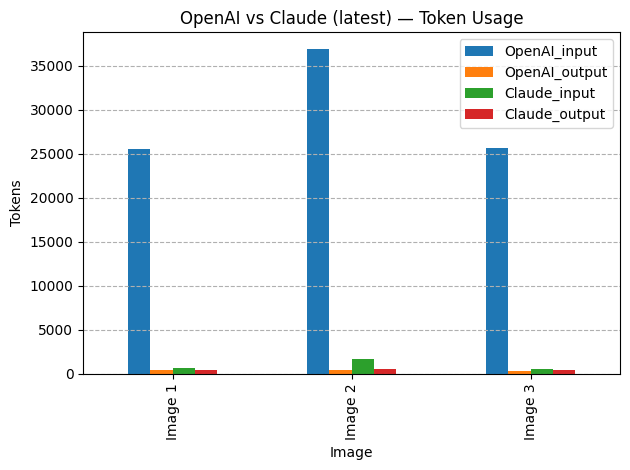

<Figure size 800x400 with 0 Axes>

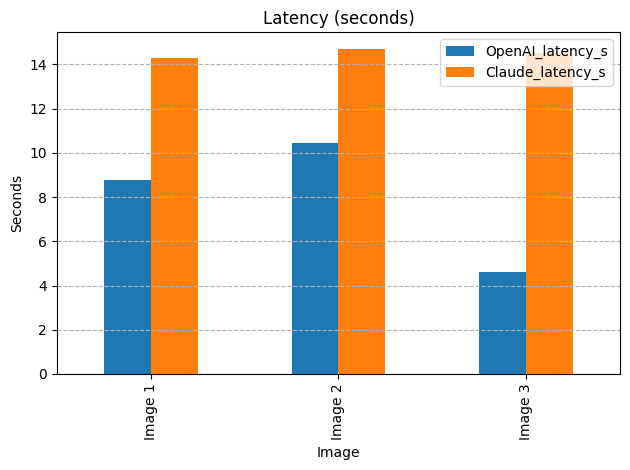

💾 Saved JSON → /content/results/defectrag_sem_20251020_061406_logs.json
💾 Saved CSV  → /content/results/defectrag_sem_20251020_061406_summary.csv


In [21]:
# 1) Get image paths
if IS_COLAB:
    print("📥 Upload exactly 3 images (PNG/JPG preferred)")
    image_paths = load_images_via_colab()
else:
    # For local Jupyter, place your files in ./uploaded_images and list them:
    image_paths = [str(p) for p in IMG_DIR.iterdir() if p.suffix.lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
    image_paths = sorted(image_paths)[:3]
    print("Found images:", image_paths)

# Ensure exactly 3 for the experiment
if len(image_paths) != 3:
    raise ValueError(f"Expected 3 images, got {len(image_paths)}. Please provide exactly three.")

# 2) Preview and describe
prompts = []
for i, path in enumerate(image_paths, start=1):
    try:
        display(Image.open(path))
    except Exception:
        pass
    prompt = input(f"Enter description for Image {i}: ")
    prompts.append(prompt)

# 3) (Optional) RAG corpus (OFF by default)
ENABLE_RAG = False
docs = names = vect = X = None, None, None, None
if ENABLE_RAG:
    docs, names = load_pdf_corpus(REF_DIR)
    if docs:
        vect, X = build_vector_store(docs)
        print(f"RAG corpus loaded: {len(docs)} documents")
    else:
        print("No PDFs found for RAG; continuing without retrieval.")

# 4) Run benchmark (Claude auto-resolves to newest 4.x)
logs = run_experiment(
    image_paths=image_paths,
    prompts=prompts,
    enable_rag=ENABLE_RAG,
    vect=vect if ENABLE_RAG else None,
    X=X if ENABLE_RAG else None,
    docs=docs if ENABLE_RAG else None,
    openai_model="gpt-4o-mini",
    claude_model_preferred=None  # leave None to auto-pick latest
)

# 5) Display responses inline
from IPython.display import Markdown
for i, entry in enumerate(logs, start=1):
    print(f"\n=== Responses for Image {i} ===")
    o_txt = (entry["openai"]["text"] or "").strip()
    a_txt = (entry["anthropic"]["text"] or "").strip()
    display(Markdown(f"####  OpenAI GPT-4o-mini\n{o_txt if o_txt else '_No output_'}"))
    display(Markdown(f"####  Anthropic Claude (latest)\n{a_txt if a_txt else '_No output_'}"))

# 6) Summarize, visualize, export
df = summarize_logs_to_df(logs)
display(df)
plot_usage(df, title="OpenAI vs Claude (latest) — Token Usage")
export_results(logs, df, run_tag=RUN_TAG)
